# **Receptive Fields:** DYNAP-SE Hardware Experiments

**Note:** The different parts of this notebook are used as modules to run different parts of the hardware experiments independently.

In [2]:
import sys
import rpyc
import time
import pickle
#import inspect
import hashlib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

import stimulus_tools as st

### Software Controller

Code for interfacing the notebook with Legacy Samna (formerly CortexControl).

Adapted from code by Nicoletta Risi at INI, Zurich.

In [2]:
"""
Created on Sun Apr  7 12:29:23 2019

Dynapse Controller

Example:
    In ctxctl Python console type:
        
        - if running in ctxctl python console:
            >>> from cortexcontrol.ctxctl_controller import DynapseController
            >>> cc = DynapseController(backend='ctxctl')    
        
        - if running in rpyc. start ctxctl in the cortexcontrol repository:
            >>> import PyCtxUtils
            >>> PyCtxUtils.start_rpyc_server()
    
    then run this file on any python notebook.

@author: nrisi
"""
class CtxCtl(object):
    
    __c = None
    
    @staticmethod 
    def get_c():
        """Connects to RPyC server started in CortexControl.
        
        If connection is already existing, return current hook.
        """
        if (CtxCtl.__c == None):
            print('Creating connection to host...')
            CtxCtl.__c = rpyc.classic.connect('localhost', 1300)   
            print('...done')
            print(CtxCtl.__c.modules.CtxDynapse)  # Prints module address
            return CtxCtl.__c
        
        else:
            print('Connection already existing')
            return CtxCtl.__c
        
        
class CtxController(object):
    
    def __init__(self, backend = 'rpyc'):
        """Wrapper around cortexcontrol functionalities
        
        Args:
            backend (str): "rpyc", or "ctxctl"
        """
        self.backend = backend
        
        if self.backend == 'rpyc':
            self._c = CtxCtl().get_c()
            #self.CtxDynapse = self._c.modules.CtxDynapse
            #self.NeuronNeuronConnector = self._c.modules.NeuronNeuronConnector
            
        #elif self.backend == "ctxctl":
            #import CtxDynapse
            #import cortexcontrol_11_02.NeuronNeuronConnector as NeuronNeuronConnector
            #self.CtxDynapse = CtxDynapse
            #self.NeuronNeuronConnector = NeuronNeuronConnector
            
        else:
            raise ValueError('Backend not valid')

In [3]:
# Create CtxCtl Controller object
cc = CtxController()

Creating connection to host...
...done
<module 'CtxDynapse' (built-in)>


### DYNAP-SE Controller

A custom module added to CortexControl, which contains tools and convenience functions for controlling the Dynap-SE neuromorphic processor.

In [4]:
# Import DYNAP-SE Controller module
cc._c.execute("import dynapse_controller")

# Create DYNAP-SE Controller object
dc = cc._c.modules.dynapse_controller.DynapseController()

# Silence all DYNAP-SE activity
dc.silence_board()

## Notebook Functions

### Data-Handling Functions

In [3]:
_HASHLEN = 20  # Hash length for SHA-1

def progress_bar(i,N):
    """Print/update progress bar for i/N iterations.
    """
    a = i
    b = N - i
    
    print('\r' + u"\u2588" * a + '.' * b + ' (' + str(i) + '/' + str(N) + ')')

def safe_pickle(obj, filename):
    """Pickle a data object, append a checksum, and write to file.
    """
    # Pickle data
    pickled_data = pickle.dumps(obj)
    
    # Append with checksum
    pickled_data += hashlib.sha1(pickled_data).digest()
    
    # Write data to file
    with open(filename, 'wb') as outfile:
        outfile.write(pickled_data)

def safe_unpickle(filename):
    """Read pickled file, check hash, and return unpickled data.
    """
    # Read data from file
    with open(filename, 'rb') as infile:
        file_data = infile.read()
    
    # Retrieve pickled data and checksum
    pickled_data, checksum = file_data[:-_HASHLEN], file_data[-_HASHLEN:]
    
    # Check hash
    if hashlib.sha1(pickled_data).digest() != checksum:
        raise ValueError("Pickle hash does not match!")
    
    # Return unpickled data
    return pickle.loads(pickled_data)

### DYNAP-SE Configuration Functions

In [6]:
def write_srams_stc(core_ids):
    """Write the SRAMs of the DYNAP-SE according to the STC network.
    
    Args:
        core_ids (dictionary):  Dictionary with core IDs of the different STC neurons.
    """
    print("Writing SRAMs for STC...")

    # SRAM ID [0,3] (#0 is used for USB)
    sram_id = 1

    # Target-core mask (binary) - target B2 core
    core_mask = 1 << core_dict['B2']

    # Loop over neurons in B1 core
    for neuron_id in range(256*core_ids['B1'], 256*core_ids['B1'] + 256):
        
        # Program SRAM of neuron
        dc.write_sram(neuron_id, sram_id, core_mask)

    print("...done")

def write_cams_stc(
    num_nets,
    num_cols,
    num_neigh,
    core_ids,
    neuron_ids,
):
    """Write the CAMs of the Dynap-SE according to the STC network.
    
    Args:
        num_cols (int):     Number of network columns
        num_neigh (int):    Number of connected neighboring columns - on each side
        core_ids (dict):    Dynap-SE core IDs for the different neuron populations
        neuron_ids (dict):  IDs of hardware neurons for network implementation
    """
    print("Writing CAMs for STC...")
    print("\tNumber of networks: "
        + str(num_nets)
        +"\n\tNumber of columns per network: "
        + str(num_cols)
        +"\n\tNumber of neighbor connections per side: "
        + str(num_neigh)
    )

    # Loop over network instances
    for net in range(num_nets):
        
        # Get global IDs of border columns
        first_col = net * num_cols
        last_col =  (net+1) * num_cols - 1

        # Loop over network columns
        for col in range(first_col, last_col+1):

            # A --> B1, fast exc.
            dc.write_cam(
                neuron_ids['A'][col],   # Pre-synaptic neuron ID
                neuron_ids['B1'][col],  # Post-synaptic neuron ID
                0,                      # CAM ID
                'exc_f'                 # Synapse type ID
            )
            
            # A --> B2, fast exc.
            dc.write_cam(
                neuron_ids['A'][col],   # Pre-synaptic neuron ID
                neuron_ids['B2'][col],  # Post-synaptic neuron ID
                0,                      # CAM ID
                'exc_f'                 # Synapse type ID
            )
            
            # B1 --> B2, shunting ("slow") inh.
            dc.write_cam(
                neuron_ids['B1'][col],  # Pre-synaptic neuron ID
                neuron_ids['B2'][col],  # Post-synaptic neuron ID
                1,                      # CAM ID
                'inh_s'                 # Synapse type ID
            )

            # Write B2 CAMs for disynaptic delays
            cam_id_B2 = 2

            # Loop over neighboring columns
            for nb_col in range (col-num_neigh, col+num_neigh + 1):

                # Check validity of neighbor column ID
                if (first_col <= nb_col) and (nb_col != col) and (nb_col <= last_col):

                    # Delay element CAMs - B1_nb --> B2
                    dc.write_cam(
                        neuron_ids['B1'][nb_col],   # Pre-synaptic neuron ID
                        neuron_ids['B2'][col],      # Post-synaptic neuron ID
                        cam_id_B2,                  # CAM ID
                        'exc_s'                     # Synapse type ID
                    )
                    cam_id_B2 += 1
                    
                    dc.write_cam(
                        neuron_ids['B1'][nb_col],   # Pre-synaptic neuron ID
                        neuron_ids['B2'][col],      # Post-synaptic neuron ID
                        cam_id_B2,                  # CAM ID
                        'inh_f'                     # Synapse type ID
                    )
                    cam_id_B2 += 1

    print("...done")
    
def write_cams_b1_tuning(core_id):
    """Write CAMs for bias-tuning of B1-population core.

    Args:
        core_id (int):  Core ID of B1 population.
    """
    print("Writing CAMs for B1 tuning...")

    # Loop over 255/256 neurons -- b/c input #0 is reserved for clearing CAMs
    for i, neuron in enumerate(range(256*core_id, 256*core_id + 256), 1):

        dc.write_cam(
            i,          # Pre-synaptic neuron ID
            neuron,     # Post-synaptic neuron ID
            0,          # CAM ID
            'exc_f'     # Synapse type ID
        )

    print("...done")
    
def write_cams_delay_tuning(core_id):
    """Write CAMs for tuning the synaptic delays in the B2 population.

    Args:
        core_id (int):  Core ID of B2 population.
    """
    print("Writing CAMs for B2 delay tuning...")

    for pre, post in enumerate(range(256*core_id, 256*(core_id+1))):

        dc.write_cam(pre, post, 0, 'exc_s')
        dc.write_cam(pre, post, 1, 'inh_f')

    print("...done")
    
def write_cams_coincidence_tuning(core_id):
    """Write CAMs for tuning the coincidence detection in B2 neurons.

    Args:
        core_id (int):  Core ID of B2 population.
    """
    print("Writing CAMs for B2 coincidence-dection tuning...")
    
    # Loop over B2 neurons
    for pre_nrn_1, post_nrn in enumerate(range(256*core_id, 256*core_id + 256)):
            
        # Delay-element input - from Core 0
        dc.write_cam(pre_nrn_1, post_nrn, 0, 'exc_s')            
        dc.write_cam(pre_nrn_1, post_nrn, 1, 'inh_f')
        
        # Direct excitation - from Core 3
        pre_nrn_2 = pre_nrn_1 + 3*256
        dc.write_cam(pre_nrn_2, post_nrn, 2, 'exc_f')
        
    print("...done")
    
def write_cams_rf_search(rf_neurons, num_lat):
    """Write CAMs for random search of receptive fields in B2 neurons. 

    Args:
        rf_neurons (list):  List of hardware RF neurons.
        num_lat (int):   Number of lateral connections per B2 neuron
    """
    print("Writing CAMs for receptive field search...")
    
    pre_nrn = 1
    
    # Loop over B2 neurons
    for post_nrn in rf_neurons:
        
        # Reset CAM index
        cam_id = 0
        
        # Loop over lateral inputs
        for lat_input in range(num_lat):
        
            # Delay-element excitation
            dc.write_cam(pre_nrn, post_nrn, cam_id, 'exc_s')            
            cam_id += 1
            dc.write_cam(pre_nrn, post_nrn, cam_id, 'inh_f')
            cam_id += 1
            pre_nrn += 1
            
        # Direct excitation
        dc.write_cam(pre_nrn, post_nrn, cam_id, 'exc_f')
        pre_nrn += 1
            
    print("...done")
    
def write_cams_sawtooth(post_nrn, num_lat, cam_ids):
    """Write CAMs for random search of receptive fields in B2 neurons. 

    Args:
        neuron_id (list):  List of hardware neurons.
        num_lat (int):     Number of lateral connections per B2 neuron
        cam_ids (list):    List of CAM IDs for synaptic connections
    """
    # Source neuron ID
    pre_nrn = 1
    
    # CAM index
    i = 0

    # Loop over lateral inputs
    for lat_input in range(num_lat):
        
        # DE exc.
        dc.write_cam(pre_nrn, post_nrn, cam_ids[i], 'exc_s')            
        
        i += 1  # Iterate CAM index
        
        # DE inh.
        dc.write_cam(pre_nrn, post_nrn, cam_ids[i], 'inh_f')
        
        i += 1        # Iterate CAM index
        pre_nrn += 1  # Iterate source-neuron ID

    # Direct exc.
    dc.write_cam(pre_nrn, post_nrn, cam_ids[i], 'exc_f')

## SNN Setup

### Hyper-Parameters

In [7]:
# Neural-network parameters

num_columns = 5  # Number of network columns
num_lateral = 4  # Number of lateral inputs to B2 per side

chip_id = 0  # Hardware chip used for experiment

# Core IDs
core_dict = {
    'A': 0,   # Input neurons (virtual)
    'B1': 2,  # Secondary input neurons
    'B2': 1   # Coincidence detection neurons (read-out layer) | Core ID inherited from previous work
}

# Hardware neuron populations
populations = {
    'A': np.arange(
        256*core_dict['A'] + 1,
        256*core_dict['A'] + 256
    ),
    'B1': np.arange(
        256*core_dict['B1'],
        256*core_dict['B1'] + 256
    ),
    'B2': np.arange(
        256*core_dict['B2'],
        256*core_dict['B2'] + 256
    )
}

# Neuron IDs
neuron_dict = {
    'A': populations['A'],
    'B1': populations['B1'], #np.random.permutation(populations['B1']),
    'B2': populations['B2'] #np.random.permutation(populations['B2'])
}

# Number of parallel instances of network
#num_networks = int(len(population_A) / num_columns)
num_networks = 1

### Initial Hardware Configuration

The memory cells of the Dynap-SE may need to be cleared everytime the device is started up.

In [8]:
# Select hardware chip to configure
dc.dynapse.set_config_chip_id(chip_id)

# Clear CAMs
print("Clearing CAMs...")
dc.clear_cams(chip_id)
print("...done")

# Clear SRAMs
print("Clearing SRAMs...")
dc.clear_all_srams()
print("...done")

Clearing CAMs...
...done
Clearing SRAMs...
...done


#### Load Bias Values

In [10]:
dc.load_biases("biases_rf.py")

In [8]:
# Set initial biases
#dc.load_biases("biases_B1.py")
#dc.load_biases("biases_B2.py")
#dc.load_biases("biases_STC_latest.py")

In [9]:
#dc.load_biases("biases_delay_tuning.py")

### Network Connections

In [9]:
# Write neuronal output-routing data to SRAMs
#write_srams_stc(core_dict)

# Write neuronal input-routing data to CAMs 
write_cams_stc(num_networks, num_columns, num_lateral, core_dict, neuron_dict)

# Monitor neurons
#dc.monitor_neuron(chip_id, neuron_dict['B1'][0])
#dc.monitor_neuron(chip_id, neuron_dict['B2'][0])

Writing CAMs for STC...
	Number of networks: 1
	Number of columns per network: 5
	Number of neighbor connections per side: 4
...done


## Bias Tuning

### B1 Tuning

#### Hardware Setup

In [27]:
# Select neuron to monitor
dc.monitor_neuron(chip_id, neuron_dict['B1'][100])

In [111]:
# Set up synaptic connections for B1-tuning
write_cams_b1_tuning(core_dict['B1'])

Writing CAMs for B1 tuning...
...done


In [41]:
# Stop previous constant spike-generation - if any
dc.stop_repeating_stim()

In [44]:
# Set up single-spike stimulus

src_neurons = range(1, 256)
isis = np.zeros(len(src_neurons))

isis[0] = 0.5   # Delay between stimulus repetitions

dc.write_spike_gen(
    isis,               # ISIs
    src_neurons,        # Source neuron IDs
    chip_id,            # Target chip ID
    #var_isi = False,    # Variable-ISI flag
    #repeat = False      # Repeat-mode flag     
)

In [243]:
dc.spike_gen.start()

In [33]:
dc.spike_gen.stop()

#### Data Processing

In [68]:
dc.monitor_neuron(chip_id, neuron_dict['B1'][0])

In [51]:
# Create buffered filter that stores events
buf_filter_B1 = dc.CtxDynapse.BufferedEventFilter(
    dc.model,
    range(256*core_dict['B1'], 256*core_dict['B1'] + 256)   # Only store events from the B1 core
)

In [35]:
# Reset buffer filter
buf = buf_filter_B1.get_events()

# Send stimulus
#dc.spike_gen.start()

time.sleep(0.4)

# Retrieve stored events
events_B1 = buf_filter_B1.get_events()

# Get numerical data from event-objects
ev_neurons_B1, ev_times_B1 = dc.events_to_raster(events_B1, global_ids = False)

ev_count_B1 = []
single_spikes_B1 = []

# Loop over B1 neurons
for neuron in range(0, 256):
    
    # Count number of events with current neuron ID
    count = ev_neurons_B1.count(neuron)
    ev_count_B1.append(count)
    
    if ev_count_B1[neuron] == 1:
        single_spikes_B1.append(neuron)

print("Average spike number:\t\t" + str(len(ev_neurons_B1) / 256))

print("Max spike number:\t\t" + str(max(ev_count_B1)))

print("Min spike number:\t\t" + str(min(ev_count_B1)))

print("No. of single-spiking neurons:\t" + str(len(single_spikes_B1)))

NameError: name 'buf_filter_B1' is not defined

In [80]:
times = (ev_times_B1 - np.min(ev_times_B1)) * 1e3

n = 0
for t in times:
    if (200 < t) and (t < 800):
        n += 1

print(n)

236


Text(0, 0.5, 'Neuron')

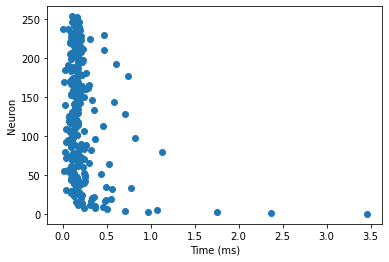

In [54]:
# Input spike-data plot
plt.scatter(
    (ev_times_B1 - np.min(ev_times_B1)) * 1e3,
    ev_neurons_B1
)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')

(array([238.,  14.,   3.,   2.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.       , 0.0059717, 0.0119434, 0.0179151, 0.0238868, 0.0298585,
        0.0358302, 0.0418019, 0.0477736, 0.0537453, 0.059717 ]),
 <BarContainer object of 10 artists>)

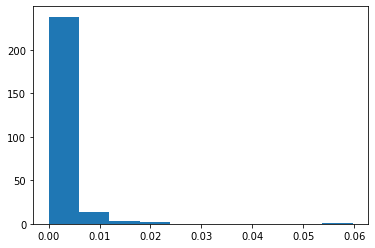

In [133]:
plt.hist(ev_times_B1 - np.min(ev_times_B1))

(array([  1.,   0.,   0.,   0.,   0., 252.,   0.,   0.,   0.,   3.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

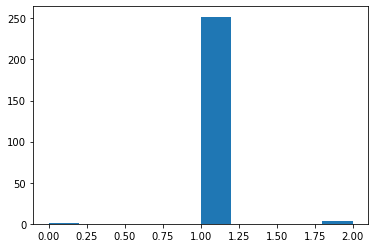

In [171]:
plt.hist(ev_count_B1)

#### Save Biases

In [10]:
dc.save_biases("biases_STC_latest.py")

#dc.save_biases("biases_rf_latest.py")

### B2 Tuning

In [18]:
# Write connections for tuning procedure
#  This needs be run *after* setting up the FPGA stimulation for some reason...

#write_cams_delay_tuning(core_dict['B2'])
write_cams_coincidence_tuning(core_dict['B2'])

Writing CAMs for B2 coincidence-dection tuning...
...done


In [10]:
# Select B1 neuron to monitor
dc.monitor_neuron(chip_id, neuron_dict['B1'][100])

In [11]:
# Select B2 neuron to monitor
dc.monitor_neuron(chip_id, neuron_dict['B2'][12])

#### Tuning Stimuli

##### Conincidence Detection Stimulus

In [104]:
# Stop stimulation
dc.spike_gen.stop()

In [105]:
print("Setting up coincidence detection stimulus...")

# ISI for coincidence detection
isi_cd = 22e-3

# Number of virtual source neurons
num_srcs = 255

# Source neuron IDs
# srcs_cd = np.arange(1, 256)
srcs_cd = np.array([])

# Loop over delay-source neurons
for i in range(1, 256):
        # Four spikes per delay-source 
        srcs_cd = np.append(srcs_cd, [i, i, i, i])

# Add source neurons for direct excitation        
srcs_cd = np.append(srcs_cd, np.arange(3*256 + 1, 4*256))

# Duplicate source-array for non-coincidence case
srcs_cd = np.append(srcs_cd, srcs_cd)

# ISI array
isis_cd = np.zeros(len(srcs_cd))
isi_ind = 0

isis_cd[isi_ind] = 0.1  # Stimulus repetition delay
isi_ind += 4*num_srcs   # Four delayed spikes per neuron

isis_cd[isi_ind] = isi_cd  # Coincidence ISI
isi_ind += num_srcs        # One direct spike per neuron 

isis_cd[isi_ind] = 0.1  # Repetition delay
isi_ind += 4*num_srcs   # Four delayed spikes per neuron

isis_cd[isi_ind] = 40e-3  # Non-coincidence ISI


dc.write_spike_gen(
    isis_cd,          # ISIs
    srcs_cd,          # Source neuron IDs
    chip_id,          # Target chip ID
    #var_isi = False,  # Variable-ISI flag
    #repeat = False    # Repeat-mode flag     
)

print("...done")

Setting up coincidence detection stimulus...
...done


In [106]:
# Start stimulation
dc.spike_gen.start()

In [107]:
print(srcs_cd[0:5])
print(isis_cd[0:5])
print('\n')

print(srcs_cd[(4*num_srcs - 5) : (4*num_srcs + 3)])
print(isis_cd[(4*num_srcs - 5) : (4*num_srcs + 3)])
print('\n')

print(srcs_cd[(5*num_srcs - 2) : (5*num_srcs + 6)])
print(isis_cd[(5*num_srcs - 2) : (5*num_srcs + 6)])
print('\n')

print(srcs_cd[(9*num_srcs - 2) : (9*num_srcs + 3)])
print(isis_cd[(9*num_srcs - 2) : (9*num_srcs + 3)])
print('\n')


[1. 1. 1. 1. 2.]
[0.1 0.  0.  0.  0. ]


[254. 255. 255. 255. 255. 769. 770. 771.]
[0.    0.    0.    0.    0.    0.022 0.    0.   ]


[1.022e+03 1.023e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00 2.000e+00
 2.000e+00]
[0.  0.  0.1 0.  0.  0.  0.  0. ]


[255. 255. 769. 770. 771.]
[0.   0.   0.04 0.   0.  ]




##### Frequency Sweep Stimulus

In [17]:
# Stimulus parameters
#t_channel = 13e-3  # Channel activation interval (s)
t_channel = 0.5  # For testing
start_delay = 0.5  # Delay between repeated stimulations (s) 

In [30]:
# Stop the spike-generator
dc.spike_gen.stop()

# Generate spike-input data
isis_B2_tuning, srcs_B2_tuning = st.gen_linear_spike_sweep(num_columns, t_channel, start_delay)

# Program FPGA spike generator
dc.write_spike_gen(isis_B2_tuning, srcs_B2_tuning, chip_id)

In [31]:
# Start stimulation
dc.spike_gen.start()

#### Data Processing

In [19]:
# Specify neurons for event filter
filter_neurons_B2 = range(256*core_dict['B2'],
                          256*core_dict['B2'] + 256)

# Create buffered filter that stores events from assigned neurons
buf_filter_B2 = dc.CtxDynapse.BufferedEventFilter(dc.model, filter_neurons_B2)

In [110]:
# Reset buffer filter
buf = buf_filter_B2.get_events()

# Start stimulation
#dc.spike_gen.start()

time.sleep(200e-3)

# Retrieve stored events
events_B2 = buf_filter_B2.get_events()

# Get numerical data from event-objects
ev_neurons_B2, ev_times_B2 = dc.events_to_raster(events_B2)

#print(len(events_A))

ev_count_B2 = []
single_spikes_B2 = []

# Loop over neuron population
for neuron in filter_neurons_B2:
    
    # Count number of events with current neuron ID
    count_B2 = ev_neurons_B2.count(neuron)
    ev_count_B2.append(count_B2)
    #print(count_B2)
    
    if count_B2 == 1:
        single_spikes_B2.append(neuron)

#print("Average spike number:\t\t" + str(len(ev_neurons_B2) / 256))

#print("Max. spike number:\t\t" + str(max(ev_count_B2)))

#print("Min. spike number:\t\t" + str(min(ev_count_B2)))

#print("Number of single spikes:\t" + str(len(single_spikes_B2)))

#print(ev_neurons_B2)

#print(ev_count_B2)

In [111]:
print(sum(ev_count_B2))

print(np.array(ev_neurons_B2) - 256)

18
[160 107 222 121  39  19  30  46  65  10  99  34  63  79  14  71 129  45]


Text(0, 0.5, 'Neuron ID')

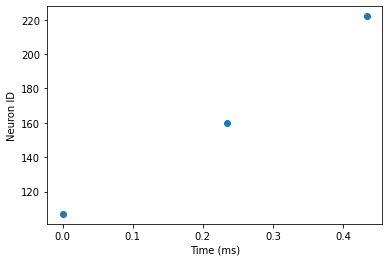

In [50]:
# B2 spike-data plot
plt.scatter(
    (ev_times_B2 - np.min(ev_times_B2)) * 1e3,
    np.array(ev_neurons_B2) - 256
)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron ID')

In [112]:
ev_neurons_B2.sort()

print(np.array(ev_neurons_B2) - 256)

[ 10  14  19  30  34  39  45  46  63  65  71  79  99 107 121 129 160 222]


In [127]:
spikes_0ms = {107, 160, 222}

spikes_5ms = {15, 30, 65, 95, 107, 129, 142, 160, 188, 205, 217, 222, 239, 248, 251}

spikes_11ms = {10, 11, 15, 30, 45, 46, 47, 63, 65, 76, 79, 95, 107, 115, 129, 160, 174, 205, 213, 230, 238}

spikes_11ms_2 = {10, 11, 15, 30, 45, 46, 47, 65, 76, 79, 95, 107, 107, 115, 129, 160, 174, 205, 213, 230, 238}

spikes_16ms = {10, 14, 15, 19, 30, 34, 35, 45, 46, 65, 74, 79, 99, 107, 129, 160, 193}

spikes_22ms = {10, 14, 19, 30, 34, 46, 63, 65, 71, 79, 99, 107, 107, 160, 160, 222}


unique_5ms = spikes_5ms.difference(spikes_0ms, spikes_11ms, spikes_16ms, spikes_22ms)
print("Neurons spiking only for ISI 5 ms:\t\t" + str(sorted(unique_5ms)) + '\n')

unique_11ms = spikes_11ms.difference(spikes_0ms, spikes_5ms, spikes_16ms, spikes_22ms)
print("Neurons spiking only for ISI 11 ms:\t\t" + str(sorted(unique_11ms))+ '\n')

unique_16ms = spikes_16ms.difference(spikes_0ms, spikes_5ms, spikes_11ms, spikes_22ms)
print("Neurons spiking only for ISI 16 ms:\t\t" + str(sorted(unique_16ms)) + '\n')

unique_22ms = spikes_22ms.difference(spikes_0ms, spikes_5ms, spikes_11ms, spikes_16ms)
print("Neurons spiking only for ISI 22 ms:\t\t" + str(sorted(unique_22ms)) + '\n')


intersection = set.intersection(spikes_5ms, spikes_11ms, spikes_16ms, spikes_22ms)
print("\nNeurons spiking for 5--22 ms:\t\t\t" + str(sorted(intersection)) + '\n')

intersection = set.intersection(spikes_11ms, spikes_16ms, spikes_22ms)
print("Neurons spiking for 11--22 ms:\t\t\t" + str(sorted(intersection)) + '\n')

intersection = set.intersection(spikes_11ms, spikes_16ms)
print("Neurons spiking for 11--16 ms:\t\t\t" + str(sorted(intersection)) + '\n')

intersection = set.intersection(spikes_16ms, spikes_22ms)
print("Neurons spiking for 16--22 ms:\t\t\t" + str(sorted(intersection)) + '\n')

Neurons spiking only for ISI 5 ms:		[142, 188, 217, 239, 248, 251]

Neurons spiking only for ISI 11 ms:		[11, 47, 76, 115, 174, 213, 230, 238]

Neurons spiking only for ISI 16 ms:		[35, 74, 193]

Neurons spiking only for ISI 22 ms:		[71]


Neurons spiking for 5--22 ms:			[30, 65, 107, 160]

Neurons spiking for 11--22 ms:			[10, 30, 46, 65, 79, 107, 160]

Neurons spiking for 11--16 ms:			[10, 15, 30, 45, 46, 65, 79, 107, 129, 160]

Neurons spiking for 16--22 ms:			[10, 14, 19, 30, 34, 46, 65, 79, 99, 107, 160]



In [13]:
responses = []

plot_neurons = []
plot_isis = []

cd_isis = [0, 5, 11, 16, 22]

cd_spike_dict = {
    0: {107, 160, 222},
    5: {15, 30, 65, 95, 107, 129, 142, 160, 188, 205, 217, 222, 239, 248, 251},
    11: {10, 11, 15, 30, 45, 46, 47, 63, 65, 76, 79, 95, 107, 115, 129, 160, 174, 205, 213, 230, 238},
    16: {10, 14, 15, 19, 30, 34, 35, 45, 46, 65, 74, 79, 99, 107, 129, 160, 193},
    22: {10, 14, 19, 30, 34, 46, 63, 65, 71, 79, 99, 107, 107, 160, 160, 222},
}

# Loop over neuron population
for neuron in range(0, 256):
    
    response = []
    
    # Loop over sampled ISIs
    for isi in cd_isis:
        
        # Check neuron response for ISI
        if neuron in cd_spike_dict[isi]:
            
            # Add ISI to neuronal response list
            response.append(isi)
            
            # Store plot data
            plot_neurons.append(neuron)
            plot_isis.append(isi)
            
    responses.append(response)

In [18]:
responding_neurons = set()

for key in cd_spike_dict.keys():
    
    responding_neurons.update(cd_spike_dict[key]) 

print(sorted(responding_neurons))
print(len(responding_neurons))

[10, 11, 14, 15, 19, 30, 34, 35, 45, 46, 47, 63, 65, 71, 74, 76, 79, 95, 99, 107, 115, 129, 142, 160, 174, 188, 193, 205, 213, 217, 222, 230, 238, 239, 248, 251]
36


In [36]:
for neuron in range(0, 256):
    
    if len(responses[neuron]) != 0:
        
        x = np.ones_like(responses[neuron]) * neuron
        
        plt.plot(x, neuron_responses[neuron], marker = 'o')
        
plt.title("Neuronal Responses")
plt.xlabel("Neuron ID")
plt.ylabel("ISI")
        
plt.show()

In [42]:
plot_ind = 1

for span in range(0, 23):
    
    for neuron in range(0, 256):
    
        if len(responses[neuron]) != 0:
            if (max(responses[neuron]) - min(responses[neuron])) == span:

                x = np.ones_like(responses[neuron]) * plot_ind

                plt.plot(x, neuron_responses[neuron], marker = 'o')
                plot_ind += 1

plt.title("Neuronal Responses")
plt.xlabel("Neuron ID")
plt.ylabel("ISI")

Text(0, 0.5, 'ISI')

Text(0, 0.5, 'No. of neurons')

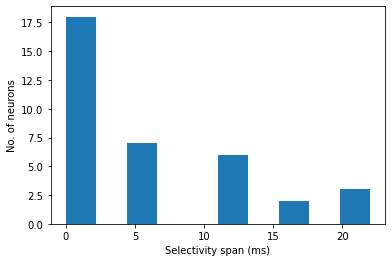

In [47]:
span = []

for neuron in range(0, 256):
    if len(responses[neuron]) != 0:
        span.append(max(responses[neuron]) - min(responses[neuron]))

plt.hist(span)

plt.xlabel("Selectivity span (ms)")
plt.ylabel("No. of neurons")

In [50]:
span.sort()
print(span)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 6, 6, 6, 6, 11, 11, 11, 11, 11, 11, 17, 17, 22, 22, 22]


#### Save Biases

In [ ]:
dc.save_biases("biases_delay_tuning_latest.py")

## Receptive-Field Search

### Hardware Setup

In [10]:
neurons_rf = np.array([
    10, 11, 14, 15, 19, 30, 34, 35, 45, 46, 47, 63, 65, 71, 74, 76, 79, 95,
    99, 107, 115, 129, 142, 160, 174, 188, 193, 205, 213, 217, 222, 230, 238,
    239, 248, 251
]) + 256*core_dict['B2']

In [11]:
print(neurons_rf)

[266 267 270 271 275 286 290 291 301 302 303 319 321 327 330 332 335 351
 355 363 371 385 398 416 430 444 449 461 469 473 478 486 494 495 504 507]


In [12]:
"""Start analog neuron monitoring.

Seemingly, this must be done before the stimulation (or event-data stream?) works.
Unclear why...
"""
dc.monitor_neuron(chip_id, neurons_rf[-3])

In [13]:
# Write connections on DYNAP-SE.
write_cams_rf_search(
    core_dict['B2'],
    neurons_rf,
    num_lateral
)

Writing CAMs for receptive field search...
...done


### Stimulus Testing

In [14]:
# Generate receptive-field stimuli
ev_times_rf, ev_sources_rf = st.gen_rand_rf_stim(len(neurons_rf), num_lateral)

In [29]:
print(ev_times_rf[:10])
print(ev_sources_rf[:10])

[-0.01868314 -0.04047462 -0.01953008 -0.00679419  0.         -0.03419978
 -0.04050202 -0.03294259 -0.02318505  0.        ]
[ 1  2  3  4  5  6  7  8  9 10]


Text(0, 0.5, 'Neuron')

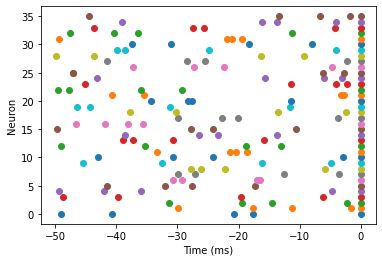

In [33]:
# Plot receptive-field stimuli
for i in range(len(neurons_rf)):
    
    start = i * (num_lateral+1)
    stop = (i+1) * (num_lateral+1)
    
    plt.scatter(
        np.array(ev_times_rf[start:stop]) * 1e3,
        np.ones(5) * i
    )

plt.xlabel('Time (ms)')
plt.ylabel('Neuron')

In [15]:
# Format event-data for DYNAP-SE
isis_rf, srcs_rf = st.events_to_lists(ev_times_rf, ev_sources_rf)

# Write receptive-field stimuli to DYNAP-SE
dc.write_spike_gen(
    isis_rf,          # ISIs
    srcs_rf,          # Source neuron IDs
    chip_id,          # Target chip ID
    #var_isi = False,  # Variable-ISI flag
    repeat = False    # Repeat-mode flag     
)

In [18]:
dc.spike_gen.start()

### Random Search

Remember to **warm up the DYNAP-SE** before running the experiment!

#### Setup

In [20]:
n_rand = int(10e3)  # Number of random-search iterations

stim_time = 100e-3  # Stimulation time

w_start = int(25e3)
w_stop = int(40e3 + 1)
w_step = int(5e3)

weights_de = range(w_start, w_stop, w_step)

n_weights = len(weights_de)

# Indices for neuron monitoring
mon_inds = range(0, 36, 8)
#mon_nrn_id = neurons_rf[mon_nrn_ind]

N = n_rand * len(weights_de)  # Total number of iterations

In [21]:
# Create buffered filter that stores events from assigned neurons
buf_filter_rf = dc.CtxDynapse.BufferedEventFilter(dc.model, neurons_rf)

#### Run

In [75]:
# List for storing stimuli
stimuli_rf = []

# Generate stimulus-data indices
start_inds = []
stop_inds = []
for nrn_ind in range(len(neurons_rf)):
    start_inds.append(nrn_ind * (num_lateral+1))
    stop_inds.append((nrn_ind+1) * (num_lateral+1))

"""Loop over weights
"""
for w_ind, weight in enumerate(tqdm(weights_de, desc='Weights')):
    
    # Set delayed-excitation weight on DYNAP-SE
    dc.groups[core_dict['B2']].set_linear_bias("PS_WEIGHT_EXC_S_N", weight)
    dc.save_biases("biases_rf_wde"
                   + str(round(weight/1e3, 1))
                   + "k.py")

    # Update analog monitoring
    mon_ind = mon_inds[w_ind]
    dc.monitor_neuron(chip_id, neurons_rf[mon_ind])
    
    """Random search iterations
    """                                    
    for iteration in tqdm(range(n_rand), desc='Stimuli'):
        
        # Generate receptive-field stimuli
        stim_times, stim_srcs = st.gen_rand_rf_stim(len(neurons_rf), num_lateral)

        # Format stimulation data for DYNAP-SE
        fpga_isis, fpga_srcs = st.events_to_lists(stim_times, stim_srcs)
        
        # Write receptive-field stimuli to DYNAP-SE
        dc.write_spike_gen(fpga_isis,
                           fpga_srcs,
                           chip_id,
                           repeat = False)

        """Start new stimulation
        """
        buf = buf_filter_rf.get_events()  # Reset event filter
        dc.dynapse.reset_timestamp()      # Reset event timestamps
        dc.spike_gen.start()              # Start stimulation
        time.sleep(stim_time)             # Freeze notebook execution

        """Retrieve DYNAP-SE spike-data
        """
        events_rf = buf_filter_rf.get_events()  # Get recorded events
        ev_nrns_rf, ev_times_rf = dc.events_to_raster(events_rf)  # Convert DYNAP-SE spike-data
        
        # Create NumPy objects of event data
        ev_nrns_rf_np = np.array(ev_nrns_rf)
        ev_times_rf_np = np.array(ev_times_rf)
        
        """Retrieve stimulus data
        """
        # Loop over receptive-field neurons
        for nrn_ind, neuron in enumerate(neurons_rf):
            
            # Check for spike-event
            if neuron in ev_nrns_rf:
                
                # Get post-synaptic event indices
                ev_inds = np.flatnonzero(ev_nrns_rf_np == neuron)

                # Stimulus source and times indices
                start_ind = start_inds[nrn_ind]
                stop_ind = stop_inds[nrn_ind] 
                
                # Store successful stimulus
                stimuli_rf.append(
                    # Create stimulus-data object
                    st.Stimulus(neuron,
                                weight,
                                stim_srcs[start_ind:stop_ind],
                                stim_times[start_ind:stop_ind],
                                ev_times_rf_np[ev_inds]))

"""Store results
"""
# Time string
time_str = time.strftime("%Y-%m-%d_%H:%M:%S")

# Generate filename
filename_out = ("rf_data_"
                + time_str
                + "_n" + str(n_rand)
                + ".pickle")

# Pickle and store data
safe_pickle(stimuli_rf, filename_out)

Weights:   0%|          | 0/4 [00:00<?, ?it/s]

Stimuli:   0%|          | 0/10000 [00:00<?, ?it/s]

Stimuli:   0%|          | 0/10000 [00:00<?, ?it/s]

Stimuli:   0%|          | 0/10000 [00:00<?, ?it/s]

Stimuli:   0%|          | 0/10000 [00:00<?, ?it/s]

#### Oscilloscope Reference Run

In [22]:
"""Random-search parameters
"""
n_rand = 1  # Number of random-search iterations

stim_time = 100e-3  # Stimulation time

w_start = int(25e3)
w_stop = int(45e3 + 1)
w_step = int(5e3)

weights_de = range(w_start, w_stop, w_step)

# List for storing stimuli
stimuli_rf = []

# Generate stimulus-data indices
start_inds = []
stop_inds = []
for nrn_ind in range(len(neurons_rf)):
    start_inds.append(nrn_ind * (num_lateral+1))
    stop_inds.append((nrn_ind+1) * (num_lateral+1))

"""Loop over weights
"""
for w_ind, weight in enumerate(tqdm(weights_de, desc='Weights')):
    
    # Set delayed-excitation weight on DYNAP-SE
    dc.groups[core_dict['B2']].set_linear_bias("PS_WEIGHT_EXC_S_N", weight)
    dc.save_biases("biases_rf_wde"
                   + str(round(weight/1e3, 1))
                   + "k.py")

    # Update analog monitoring
    mon_ind = mon_inds[w_ind]
    dc.monitor_neuron(chip_id, neurons_rf[mon_ind])
    
    """Random search iterations
    """                                    
    for iteration in tqdm(range(n_rand), desc='Stimuli'):
        
        # Generate receptive-field stimuli
        stim_times, stim_srcs = st.gen_rand_rf_stim(len(neurons_rf), num_lateral)

        # Format stimulation data for DYNAP-SE
        fpga_isis, fpga_srcs = st.events_to_lists(stim_times, stim_srcs)
        
        # Write receptive-field stimuli to DYNAP-SE
        dc.write_spike_gen(
            fpga_isis,        # ISIs
            fpga_srcs,        # Source neuron IDs
            chip_id,          # Target chip ID
            #var_isi = False,  # Variable-ISI flag
            repeat = False    # Repeat-mode flag     
        )

        """Start new stimulation
        """
        buf = buf_filter_rf.get_events()  # Reset event filter
        dc.dynapse.reset_timestamp()      # Reset event timestamps
        dc.spike_gen.start()              # Start stimulation
        time.sleep(stim_time)             # Freeze notebook execution

        """Retrieve DYNAP-SE spike-data
        """
        events_rf = buf_filter_rf.get_events()  # Get recorded events
        ev_nrns_rf, ev_times_rf = dc.events_to_raster(events_rf)  # Convert DYNAP-SE spike-data
        
        # Create NumPy objects of event data
        ev_nrns_rf_np = np.array(ev_nrns_rf)
        ev_times_rf_np = np.array(ev_times_rf)
        
        """Retrieve stimulus data
        """
        # Loop over receptive-field neurons
        for nrn_ind, neuron in enumerate(neurons_rf):
            
            # Check for spike-event
            #if neuron in ev_nrns_rf:
                
            # Get post-synaptic event indices
            ev_inds = np.flatnonzero(ev_nrns_rf_np == neuron)

            # Stimulus source and times indices
            start_ind = start_inds[nrn_ind]
            stop_ind = stop_inds[nrn_ind] 

            # Store successful stimulus
            stimuli_rf.append(
                # Create stimulus-data object
                st.Stimulus(
                    neuron,                          # Post-syn. neuron ID
                    weight,                          # Delayed-exc. weight
                    stim_srcs[start_ind:stop_ind],   # Pre-syn. neuron IDs
                    stim_times[start_ind:stop_ind],  # Pre-syn. spike-times
                    ev_times_rf_np[ev_inds],         # First post-syn. spike-time
                )
            )
                
# Time string
time_str = time.strftime("%Y-%m-%d_%H:%M:%S")

# Generate filename
filename_out = ("rf_data_"
                + time_str
                + "_n" + str(n_rand)
                + ".pickle")

# Pickle and store data
safe_pickle(stimuli_rf, filename_out)

Weights:   0%|          | 0/5 [00:00<?, ?it/s]

Stimuli:   0%|          | 0/1 [00:00<?, ?it/s]

Stimuli:   0%|          | 0/1 [00:00<?, ?it/s]

Stimuli:   0%|          | 0/1 [00:00<?, ?it/s]

Stimuli:   0%|          | 0/1 [00:00<?, ?it/s]

Stimuli:   0%|          | 0/1 [00:00<?, ?it/s]

In [69]:
print(len(stimuli_rf))

print(stimuli_rf[-1].neuron_id)
print(stimuli_rf[-1].weight_de)
print(stimuli_rf[-1].source_ids)
print(stimuli_rf[-1].pre_times)
print(stimuli_rf[-1].post_times)

10819
330
35000
[71 72 73 74 75]
[-0.01258223 -0.01426522 -0.01045887 -0.00818223  0.        ]
[0.060378]


#### Store Data to File

In [72]:
# Time string
time_str = time.strftime("%Y-%m-%d_%H:%M:%S")

# Generate filename
filename_out = ("rf_data_"
                + time_str
                + "_n" + str(n_rand)
                + ".pickle")

#print(filename_out)

# Pickle data
safe_pickle(stimuli_rf, filename_out)

#### Read Data from File

In [50]:
# Declare name of file to be read
filenames_in = [
    "rf_data_w10-50k_n1000.pickle",
    "rf_data_w25-45k_n1000.pickle"
]

# Choose file, load, and unpickle the data
stimuli_rf = safe_unpickle(filenames_in[1])

## Random CAM Search

### Setup

In [11]:
n_rand_cam = 200    # Number of random CAM combinations
n_stim = 10         # Number of stimulations per CAM combination
stim_time = 100e-3  # Time per stimulation

# Receptive-field neuron
neuron = 504

# Delayed-excitation weight
w_de = int(40e3)
dc.groups[core_dict['B2']].set_linear_bias("PS_WEIGHT_EXC_S_N", w_de)


# Stimulus source neurons
stim_neurons = range(1, num_lateral+2)

# "Sawtooth" stimulus
stim_times_reg = np.array([-20, -10, -20, -10, 0]) * 1e-3

# Inverse "sawtooth" stimulus
stim_times_inv = np.array([-10, -20, -10, -20, 0]) * 1e-3

# Format stimuli for DYNAP-SE
isis_reg, srcs_reg = st.events_to_lists(stim_times_reg, stim_neurons)
isis_inv, srcs_inv = st.events_to_lists(stim_times_inv, stim_neurons)

In [12]:
"""Start analog neuron monitoring.

Seemingly, this must be done before the stimulation (or event-data monitoring?) works.
Unclear why...
"""
dc.monitor_neuron(chip_id, neuron)

In [21]:
print(stim_neurons)

print()
print(stim_times_reg)
print(isis_reg)
print(srcs_reg)

print()
print(stim_times_inv)
print(isis_inv)
print(srcs_inv)

range(1, 6)

[-0.02 -0.01 -0.02 -0.01  0.  ]
[0.0, 0.0, 0.01, 0.0, 0.01]
[1, 3, 2, 4, 5]

[-0.01 -0.02 -0.01 -0.02  0.  ]
[0.0, 0.0, 0.01, 0.0, 0.01]
[2, 4, 1, 3, 5]


In [22]:
# Create buffered filter that stores events from assigned neurons
buf_filter_cam = dc.CtxDynapse.BufferedEventFilter(dc.model, [neuron])

### Run

In [23]:
# Lists for storing CAM combinations and spike responses
cam_id_list = []
n_spk_reg_list = []
n_spk_inv_list = []

"""Loop over randomized CAM combinations
"""
for it in tqdm(range(int(n_rand_cam)), desc="CAM combinations"):

    # Generate and program random CAMs
    cam_ids = np.random.permutation(64)[:2*num_lateral+1]
    write_cams_sawtooth(neuron, num_lateral, cam_ids)

    """Regular pattern
    """
    # Write regular stimulus to DYNAP-SE
    dc.write_spike_gen(isis_reg, srcs_reg, chip_id, repeat = False)
    
    # Reset event filter
    buf = buf_filter_cam.get_events()
    
    """ Loop over stimulations
    """
    for stim_it in range(n_stim):
    
        # Start new stimulation
        dc.spike_gen.start()   # Start stimulation
        time.sleep(stim_time)  # Freeze notebook execution

    #Retrieve DYNAP-SE spike-data
    events_cam = buf_filter_cam.get_events()  # Get recorded events
    ev_nrns_cam, ev_times_cam = dc.events_to_raster(events_cam)  # Convert DYNAP-SE spike-data

    # Count spikes
    n_spk_reg = len(ev_times_cam)
    #print("n_spk_reg = " + str(n_spk_reg))
    
    """Inverse pattern
    """
    # Write inverse stimulus to DYNAP-SE
    dc.write_spike_gen(isis_inv, srcs_inv, chip_id, repeat = False)
    
    # Reset event filter
    buf = buf_filter_cam.get_events()
    
    # Loop over stimulations (inverse pattern)
    for stim_it in range(n_stim):
    
        #Start new stimulation
        dc.spike_gen.start()   # Start stimulation
        time.sleep(stim_time)  # Freeze notebook execution

    # Retrieve DYNAP-SE spike-data
    events_cam = buf_filter_cam.get_events()  # Get recorded events
    ev_nrns_cam, ev_times_cam = dc.events_to_raster(events_cam)  # Convert DYNAP-SE spike-data
    
    # Count spikes
    n_spk_inv = len(ev_times_cam)
    #print("n_spk_inv = " + str(n_spk_inv))
    
    # Calculate spike-number difference
    n_spk_diff = n_spk_reg - n_spk_inv
    #print("n_spk_diff = " + str(n_spk_diff) + '\n')
    
    #if n_spk_diff > 0:
    cam_id_list.append(cam_ids)
    n_spk_reg_list.append(n_spk_reg)
    n_spk_inv_list.append(n_spk_inv)
    
    """Clear CAMs
    """
    for cam_id in cam_ids:
        dc.write_cam(0, neuron, cam_id, 'exc_f')
        
    """    
    if n_spk_reg > 0 and n_spk_inv == 0:
        print("Pattern detector found.")
        break
    """

CAM combinations:   0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [24]:
#print(cam_id_list)
print("Regular pattern spike responses:")
print(n_spk_reg_list)

print()
print("Inverse pattern spike responses:")
print(n_spk_inv_list)

print()
print("n_reg - n_inv:")
print(np.array(n_spk_reg_list) - np.array(n_spk_inv_list))

Regular pattern spike responses:
[10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 9, 1, 0, 3, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0]

Inverse pattern spike responses:
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 0, 0, 0, 9, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

n_reg - n_inv:
[  0   0   0   0   0   0   0   0 -10 -10 -10   0   0   9   1  -9  -7  10
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0

### Store Data

In [42]:
safe_pickle(n_spk_reg_list, "n_spk_reg.pickle")
safe_pickle(n_spk_inv_list, "n_spk_inv.pickle")
safe_pickle(cam_id_list, "cam_ids.pickle")

### Load Data

In [4]:
n_spk_reg_arr = np.array(safe_unpickle("n_spk_reg_1.pickle"))
n_spk_inv_arr = np.array(safe_unpickle("n_spk_inv_1.pickle"))
cam_id_arr = np.array(safe_unpickle("cam_ids_1.pickle"))

In [5]:
diff = np.array(n_spk_reg_arr) - np.array(n_spk_inv_arr)

inds = np.flatnonzero(diff == 10)

In [6]:
print(inds)
print()
print(cam_id_arr[inds])
print()
print(n_spk_reg_arr[inds])
print()
print(n_spk_inv_arr[inds])
print()
print(cam_id_arr[inds[-1]])

[ 0  4 58 85]

[[ 2 30 54 15 46  6  4 51 56]
 [31  9 50  2 41 45 36 25 49]
 [25  2 45 42 28 57 16 50 24]
 [55 60 16  3 63 38 54 19  2]]

[10 10 10 10]

[0 0 0 0]

[55 60 16  3 63 38 54 19  2]


### Receptive Field Search

Remember to **warm up the DYNAP-SE** before running the experiment!

#### Setup

In [26]:
n_rand = int(1e4)  # Number of random-search iterations
n_cam = len(inds)

stim_time = 100e-3  # Stimulation time

#cam_ids = cam_id_arr[inds]

In [27]:
# Create buffered filter that stores events from assigned neurons
buf_filter_rf = dc.CtxDynapse.BufferedEventFilter(dc.model, [neuron])

In [23]:
print(cam_id_arr[0])
print()
print(cam_id_arr[1])
print()
print(cam_id_arr[2])
print()
print(cam_id_arr[3])

[ 2 30 54 15 46  6  4 51 56]

[ 7 17 60  1 32  0 50 42 61]

[58 37 51 53  1 29 47 31  9]

[45  5 35 11 62 54  6 39 50]


#### Run

In [28]:
inds = [
    0,
    4,
    58,
    85,
]

# List for storing stimuli
stimuli_rf = []

"""Loop over CAM configurations
"""
for ind in tqdm(inds, desc = "CAM combinations"):
    
    # Update CAM configuration on DYNAP-SE
    write_cams_sawtooth(neuron, num_lateral, cam_id_arr[ind])
    
    """Random search iterations
    """                                    
    for iteration in tqdm(range(n_rand), desc = "Stimuli"):
        
        # Generate receptive-field stimuli
        stim_times, stim_srcs = st.gen_rand_rf_stim(1, num_lateral)

        # Format stimulation data for DYNAP-SE
        fpga_isis, fpga_srcs = st.events_to_lists(stim_times, stim_srcs)
        
        # Write receptive-field stimuli to DYNAP-SE
        dc.write_spike_gen(fpga_isis,
                           fpga_srcs,
                           chip_id,
                           repeat = False)

        """Start new stimulation
        """
        buf = buf_filter_rf.get_events()  # Reset event filter
        dc.dynapse.reset_timestamp()      # Reset event timestamps
        dc.spike_gen.start()              # Start stimulation
        time.sleep(stim_time)             # Freeze notebook execution

        """Retrieve DYNAP-SE spike-data
        """
        events_rf = buf_filter_rf.get_events()  # Get recorded events
        ev_nrns_rf, ev_times_rf = dc.events_to_raster(events_rf)  # Convert DYNAP-SE spike-data
        
        # Create NumPy objects of event data
        ev_nrns_rf_np = np.array(ev_nrns_rf)
        ev_times_rf_np = np.array(ev_times_rf)
        
        """Retrieve stimulus data
        """ 
        # Check for spike-event
        if neuron in ev_nrns_rf:

            # Store successful stimulus
            stimuli_rf.append(
                # Create stimulus-data object
                st.CamStimulus(neuron,
                               ind,
                               stim_srcs,
                               stim_times,
                               ev_times_rf_np))
            
    """Clear CAMs
    """
    for cam_id in cam_id_arr[ind]:
        dc.write_cam(0, neuron, cam_id, 'exc_f')

"""Store results
"""
# Time string
time_str = time.strftime("%Y-%m-%d_%H:%M:%S")

# Generate filename
filename_out = ("cam_rf_data_"
                + time_str
                + "_n" + str(n_rand)
                + ".pickle")

# Pickle and store data
safe_pickle(stimuli_rf, filename_out)

CAM combinations:   0%|          | 0/4 [00:00<?, ?it/s]

Stimuli:   0%|          | 0/10000 [00:00<?, ?it/s]

Stimuli:   0%|          | 0/10000 [00:00<?, ?it/s]

Stimuli:   0%|          | 0/10000 [00:00<?, ?it/s]

Stimuli:   0%|          | 0/10000 [00:00<?, ?it/s]

#### Oscilloscope Reference Run

In [22]:
"""Random-search parameters
"""
n_rand = 1  # Number of random-search iterations

stim_time = 100e-3  # Stimulation time

w_start = int(25e3)
w_stop = int(45e3 + 1)
w_step = int(5e3)

weights_de = range(w_start, w_stop, w_step)

# List for storing stimuli
stimuli_rf = []

# Generate stimulus-data indices
start_inds = []
stop_inds = []
for nrn_ind in range(len(neurons_rf)):
    start_inds.append(nrn_ind * (num_lateral+1))
    stop_inds.append((nrn_ind+1) * (num_lateral+1))

"""Loop over weights
"""
for w_ind, weight in enumerate(tqdm(weights_de, desc='Weights')):
    
    # Set delayed-excitation weight on DYNAP-SE
    dc.groups[core_dict['B2']].set_linear_bias("PS_WEIGHT_EXC_S_N", weight)
    dc.save_biases("biases_rf_wde"
                   + str(round(weight/1e3, 1))
                   + "k.py")

    # Update analog monitoring
    mon_ind = mon_inds[w_ind]
    dc.monitor_neuron(chip_id, neurons_rf[mon_ind])
    
    """Random search iterations
    """                                    
    for iteration in tqdm(range(n_rand), desc='Stimuli'):
        
        # Generate receptive-field stimuli
        stim_times, stim_srcs = st.gen_rand_rf_stim(len(neurons_rf), num_lateral)

        # Format stimulation data for DYNAP-SE
        fpga_isis, fpga_srcs = st.events_to_lists(stim_times, stim_srcs)
        
        # Write receptive-field stimuli to DYNAP-SE
        dc.write_spike_gen(
            fpga_isis,        # ISIs
            fpga_srcs,        # Source neuron IDs
            chip_id,          # Target chip ID
            #var_isi = False,  # Variable-ISI flag
            repeat = False    # Repeat-mode flag     
        )

        """Start new stimulation
        """
        buf = buf_filter_rf.get_events()  # Reset event filter
        dc.dynapse.reset_timestamp()      # Reset event timestamps
        dc.spike_gen.start()              # Start stimulation
        time.sleep(stim_time)             # Freeze notebook execution

        """Retrieve DYNAP-SE spike-data
        """
        events_rf = buf_filter_rf.get_events()  # Get recorded events
        ev_nrns_rf, ev_times_rf = dc.events_to_raster(events_rf)  # Convert DYNAP-SE spike-data
        
        # Create NumPy objects of event data
        ev_nrns_rf_np = np.array(ev_nrns_rf)
        ev_times_rf_np = np.array(ev_times_rf)
        
        """Retrieve stimulus data
        """
        # Loop over receptive-field neurons
        for nrn_ind, neuron in enumerate(neurons_rf):
            
            # Check for spike-event
            #if neuron in ev_nrns_rf:
                
            # Get post-synaptic event indices
            ev_inds = np.flatnonzero(ev_nrns_rf_np == neuron)

            # Stimulus source and times indices
            start_ind = start_inds[nrn_ind]
            stop_ind = stop_inds[nrn_ind] 

            # Store successful stimulus
            stimuli_rf.append(
                # Create stimulus-data object
                st.Stimulus(
                    neuron,                          # Post-syn. neuron ID
                    weight,                          # Delayed-exc. weight
                    stim_srcs[start_ind:stop_ind],   # Pre-syn. neuron IDs
                    stim_times[start_ind:stop_ind],  # Pre-syn. spike-times
                    ev_times_rf_np[ev_inds],         # First post-syn. spike-time
                )
            )
                
# Time string
time_str = time.strftime("%Y-%m-%d_%H:%M:%S")

# Generate filename
filename_out = ("rf_data_"
                + time_str
                + "_n" + str(n_rand)
                + ".pickle")

# Pickle and store data
safe_pickle(stimuli_rf, filename_out)

Weights:   0%|          | 0/5 [00:00<?, ?it/s]

Stimuli:   0%|          | 0/1 [00:00<?, ?it/s]

Stimuli:   0%|          | 0/1 [00:00<?, ?it/s]

Stimuli:   0%|          | 0/1 [00:00<?, ?it/s]

Stimuli:   0%|          | 0/1 [00:00<?, ?it/s]

Stimuli:   0%|          | 0/1 [00:00<?, ?it/s]